In [84]:
import json
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import cmp_to_key

sns.set_theme(font='Fira Code', font_scale=0.8, style='whitegrid')
sns.set_style({'grid.linestyle': ':'})

import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_filename(crawl, climb, size, mass, count):
    return f'../data/crawl_{crawl}_climb_{climb}_size_{size}_mass_{mass}_cnt_{count}.json';

In [5]:
crawl, climb, size, mass, count = '0.2', '0.2', '0', '0', 100
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
        data = json.load(file)
points = data['points']

In [6]:
def equal(a, b):
    return a['x'] == b['x'] and a['y'] == b['y']

In [7]:
def orientation(a, b, c):
    v = a['x']*(b['y']-c['y']) + b['x']*(c['y']-a['y']) + c['x']*(a['y']-b['y'])
    if v < 0:
        return -1
    if v > 0:
        return 1
    return 0;

In [53]:
def get_boundary_alt(a_raw, thresh_base = 30, error_y = 10):
    a = a_raw[::]
    
    def compare(p1, p2):
        if p1['x'] == p2['x']:
            return p1['y'] - p2['y']
        return p1['x'] - p2['x']

    def get_dist(p1, p2):
        dx = p1['x']-p2['x']
        dy = p1['y']-p2['y']

        return math.sqrt(dx*dx + dy*dy)
        
    a = sorted(a, key=cmp_to_key(compare))
    # print(a)
    
    b = [a[-1]]
    cp = a[-1]
    a.pop()

    while len(a):
        final_ideal = {'x': 0, 'y': 0}
        final_ideal_m = 0
        
        first_pos = {'x': 0, 'y': 0}
        first_pos_m = 0
        
        final_found = False
        
        for m in range(1, 10+1):
            threshold = m*thresh_base
            ideal = {'x': 0, 'y': 0}
            ideal_y, found = 0, False
            for p in a:
                if get_dist(cp, p) <= threshold:
                    if p['y'] > ideal_y:
                        ideal_y = p['y']
                        ideal = p
                        found = True
            if found:
                if not final_found:
                    final_ideal = ideal
                    final_ideal_m = m
                    final_found = True
                if ideal['y'] >= cp['y'] - error_y and not first_pos_m:
                    first_pos = ideal
                    first_pos_m = m
                    
        to_take = first_pos if first_pos_m else final_ideal
        
        if final_ideal['y'] >= first_pos['y']:
            to_take = final_ideal
        
        if not final_found or not len(a):
            break;
        while a[-1] != to_take:
            a.pop()
            
        cp = to_take
        b.append(to_take)
        a.pop()
        
    return b[::-1];

In [81]:
def get_boundary(a, n = 20):
    chunk = 1000 // n;
    best = [0 for i in range(n)]

    for p in a:
        h = math.floor(p['x'] / chunk)
        best[h] = max(best[h], p['y'])

    def non_zero(p):
        return p['y'] != 0
        
    return list(filter(non_zero, [{ 'x': float(chunk*i), 'y': best[i] } for i in range(n)]))

In [88]:
crawl, climb, size, mass, count = '0.2', '0.2', '0', '0', 100
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
    data = json.load(file)
points = data['points']
_ = get_boundary(points)

In [37]:
def get_curvature(points):
    if len(points) < 3:
        return []

    tangs = np.diff(points, axis=0)
    curvs = []
    
    for i in range(len(tangs)-1):
        v1 = tangs[i]
        v2 = tangs[i+1]
        
        dotp = np.dot(v1, v2)
        prod_mag = np.linalg.norm(v1) * np.linalg.norm(v2)
        
        if prod_mag == 0:
            cos_theta = 1.0
        else:
            cos_theta = dotp / prod_mag
            
        curvature = 2 * (1 - cos_theta)
        curvs.append(curvature)
        
    return np.mean(curvs)

In [89]:
def display(points):
    ch_points = get_boundary(points)
    
    y_thresh = 20
    
    min_x = min(point['x'] for point in data['points'] if point['y'] < y_thresh)
    max_x = max(point['x'] for point in data['points'] if point['y'] < y_thresh)
    
    ch_points = list(filter(lambda pt: pt['y'] >= y_thresh or pt['x'] <= min_x or pt['x'] >= max_x, ch_points))
    
    np_points = [np.array([p['x'], p['y'], 0]) for p in ch_points]
    print(f"Curvature: {get_curvature(np_points):.4f}")
    
    rows = []

    max_x = max([point['x'] for point in data['points']])
    min_x = min([point['x'] for point in data['points']])
    
    halved = (max_x + min_x) / 2
    
    for i in range(len(points)):
        on_hull = False
        if points[i] in ch_points:
            on_hull = True
        rows.append([points[i]['x']-halved, -points[i]['y'], 'Yes' if on_hull else 'No'])
        
    df = pd.DataFrame(rows, columns=['x', 'y', 'On Hull'])
    
    rows = [];
    
    for i in range(len(ch_points)):
        rows.append([ch_points[i]['x']-halved, -ch_points[i]['y'], 'Yes'])
    
    df_hull = pd.DataFrame(rows, columns=['x', 'y', 'On Hull'])

    palette_duo = ["#878c2a", "#e8edbf"]

    first_no = df['On Hull'][0] == 'No'
    
    if first_no:
        palette_duo = palette_duo[::-1]
    
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(x='x', y='y', data=df, hue='On Hull', palette=palette_duo, legend=False, alpha=0.8, size=4)
    sns.lineplot(x='x', y='y', data=df_hull, c=palette_duo[1] if first_no else palette_duo[0], alpha=0.8, size=4, linestyle='--', legend=False, sort=False)
    
    ax.set_xlim([-500, 500])
    ax.set_ylim([-666, 0])
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    
    plt.show()

Curvature: 0.1087


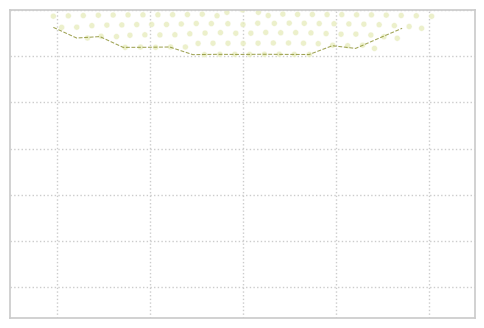

In [90]:
crawl, climb, size, mass, count = '0.2', '0.2', '0', '0', 100
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
    data = json.load(file)
points = data['points']
display(points)

### **Timelapse...**

Curvature: 0.1457


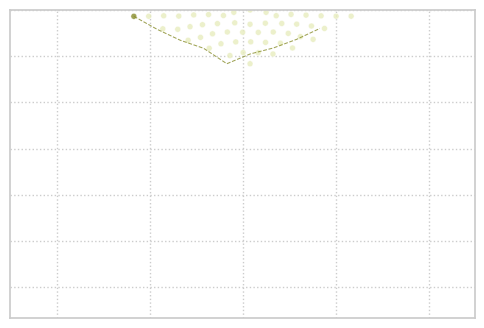

In [91]:
crawl, climb, size, mass, count = '0.4', '0.4', '0', '0', 50
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
    data = json.load(file)
points = data['points']
display(points)

Curvature: 0.1069


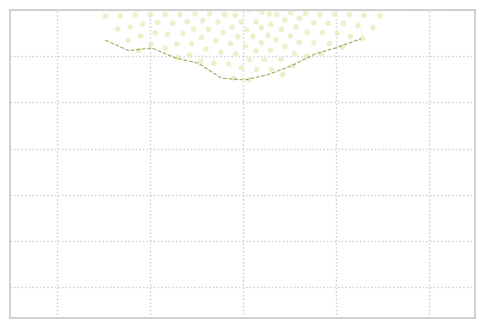

In [92]:
crawl, climb, size, mass, count = '0.4', '0.4', '0', '0', 100
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
    data = json.load(file)
points = data['points']
display(points)

Curvature: 0.2181


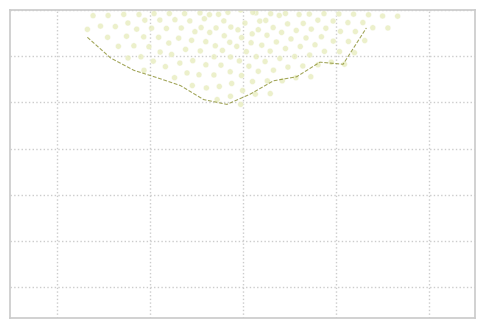

In [93]:
crawl, climb, size, mass, count = '0.4', '0.4', '0', '0', 150
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
    data = json.load(file)
points = data['points']
display(points)

Curvature: 0.2202


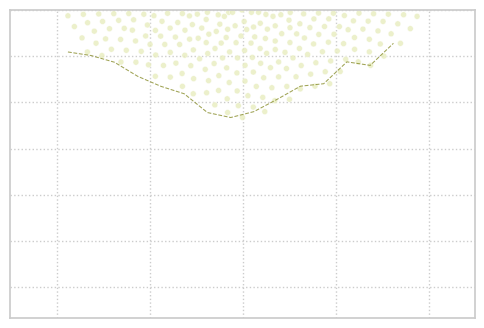

In [94]:
crawl, climb, size, mass, count = '0.4', '0.4', '0', '0', 200
filename = get_filename(crawl, climb, size, mass, count)
with open(filename, 'r') as file:
    data = json.load(file)
points = data['points']
display(points)

### **Gallery**

crawl: 0, climb 0
Curvature: 0.1190


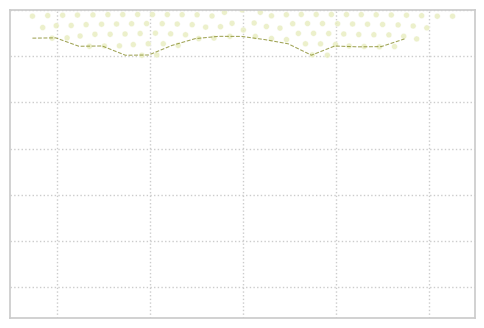

crawl: 0, climb 0.2
Curvature: 0.1179


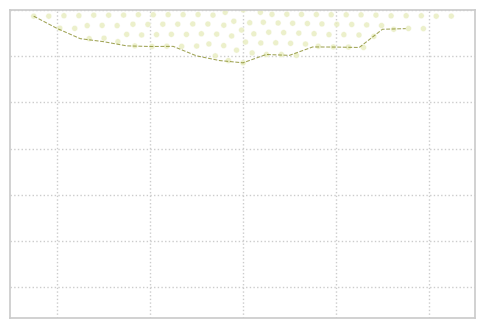

crawl: 0, climb 0.4
Curvature: 0.1357


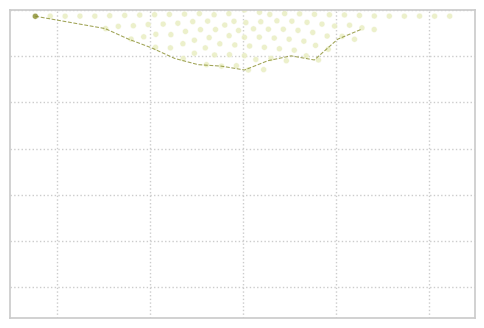

crawl: 0, climb 0.6
Curvature: 0.1309


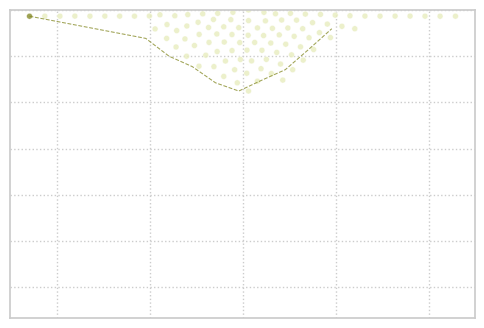

crawl: 0, climb 0.8
Curvature: 0.2591


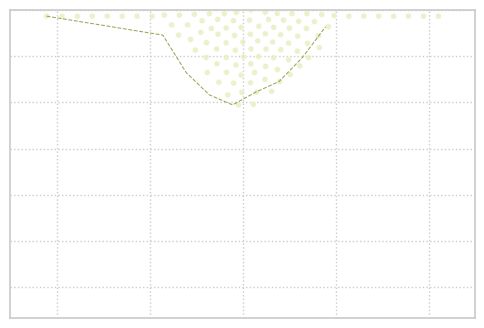

crawl: 0, climb 1
Curvature: 0.2884


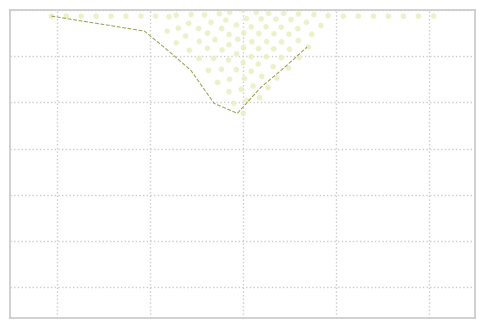

crawl: 0.2, climb 0
Curvature: 0.1369


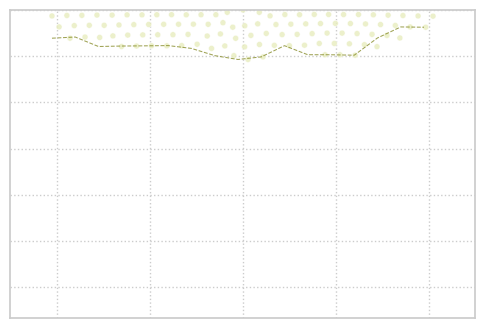

crawl: 0.2, climb 0.2
Curvature: 0.1087


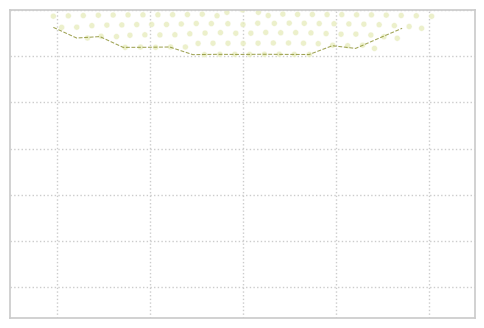

crawl: 0.2, climb 0.4
Curvature: 0.0417


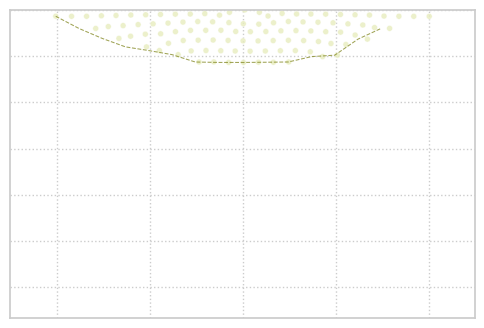

crawl: 0.2, climb 0.6
Curvature: 0.1079


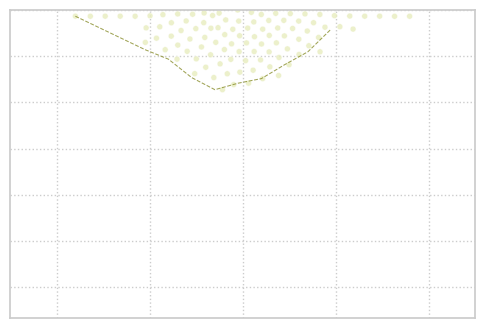

crawl: 0.2, climb 0.8
Curvature: 0.2591


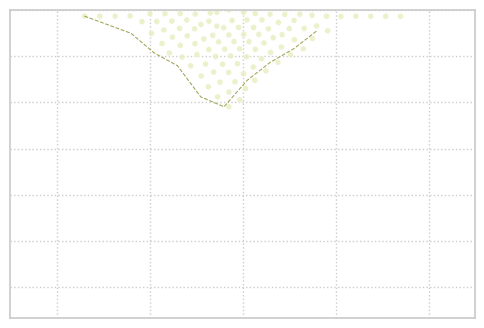

crawl: 0.2, climb 1
Curvature: 0.2747


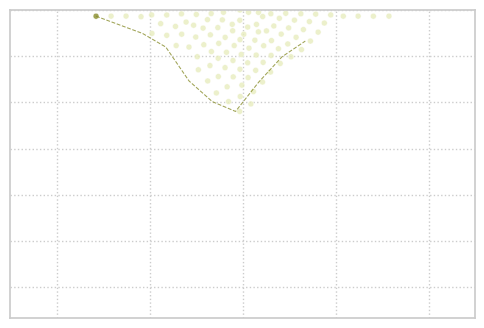

crawl: 0.4, climb 0
Curvature: 0.0906


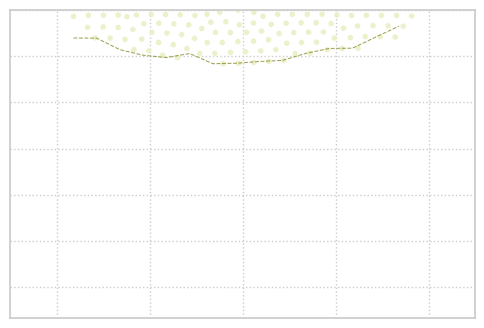

crawl: 0.4, climb 0.2
Curvature: 0.1660


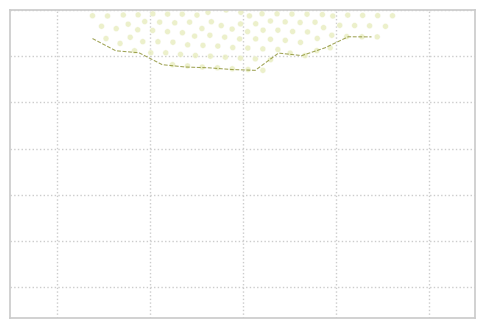

crawl: 0.4, climb 0.4
Curvature: 0.1069


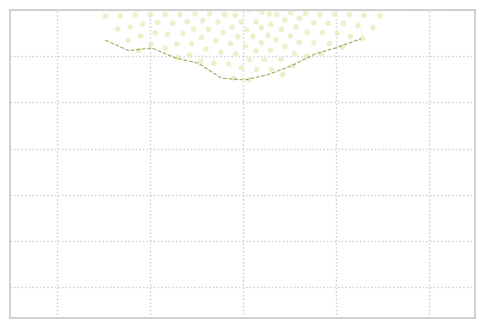

crawl: 0.4, climb 0.6
Curvature: 0.1387


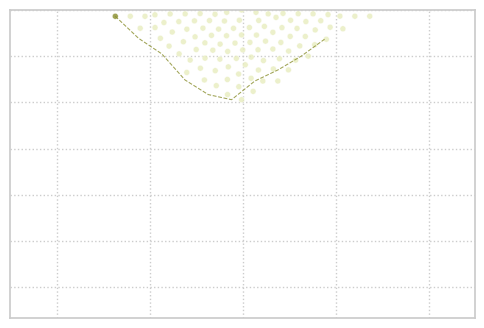

crawl: 0.4, climb 0.8
Curvature: 0.2715


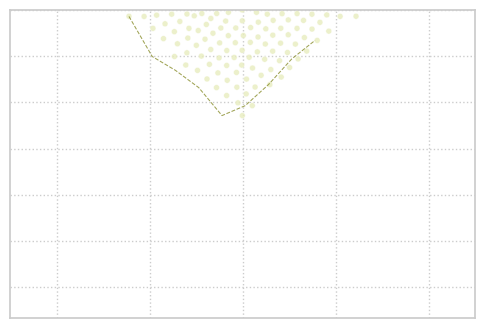

crawl: 0.4, climb 1
Curvature: 0.3040


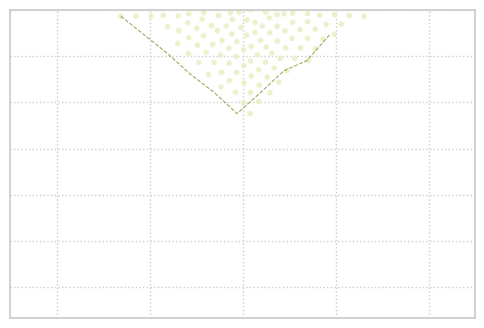

crawl: 0.6, climb 0
Curvature: 0.1221


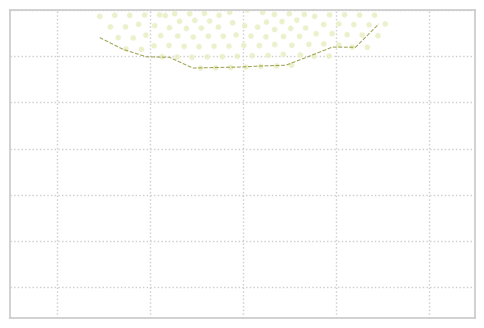

crawl: 0.6, climb 0.2
Curvature: 0.1238


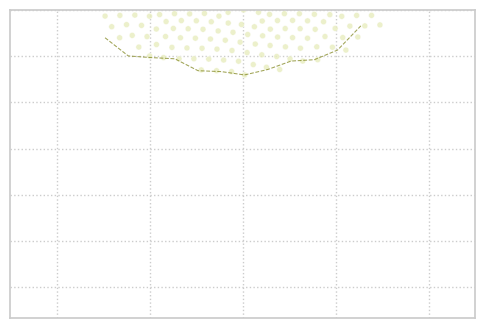

crawl: 0.6, climb 0.4
Curvature: 0.1321


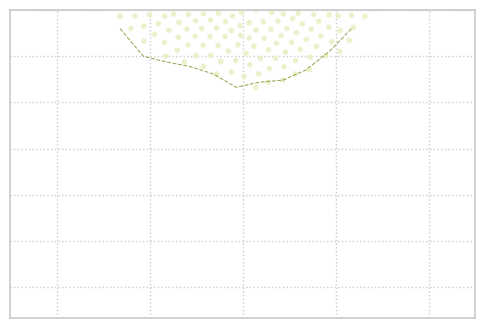

crawl: 0.6, climb 0.6
Curvature: 0.0965


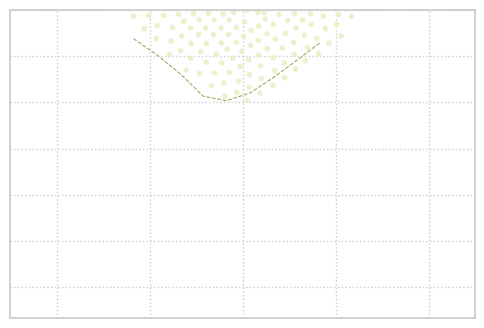

crawl: 0.6, climb 0.8
Curvature: 0.1525


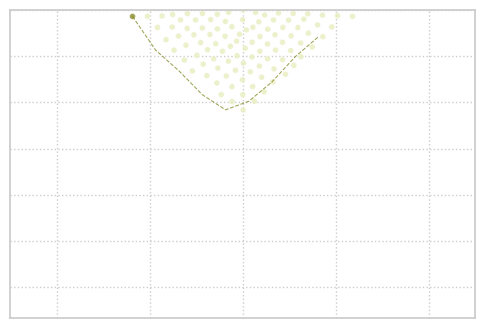

crawl: 0.6, climb 1
Curvature: 0.2680


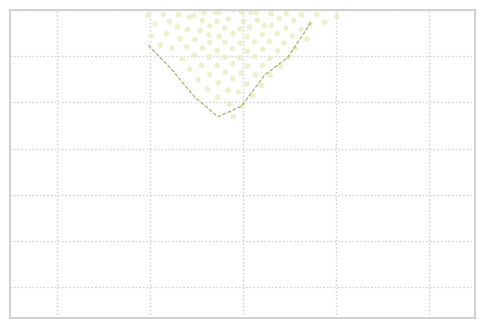

crawl: 0.8, climb 0
Curvature: 0.0600


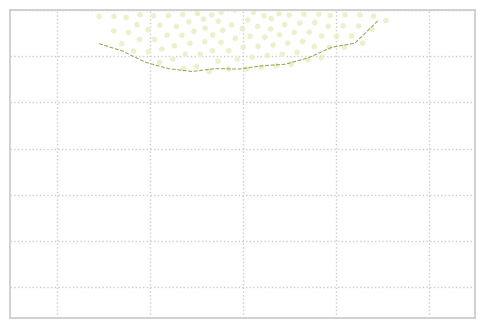

crawl: 0.8, climb 0.2
Curvature: 0.0502


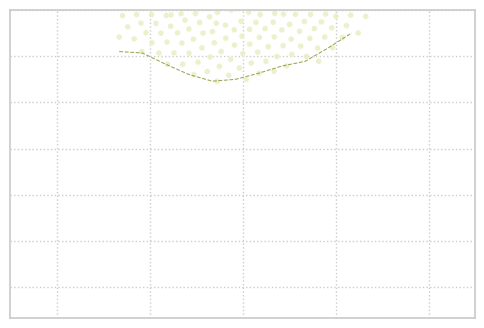

crawl: 0.8, climb 0.4
Curvature: 0.1610


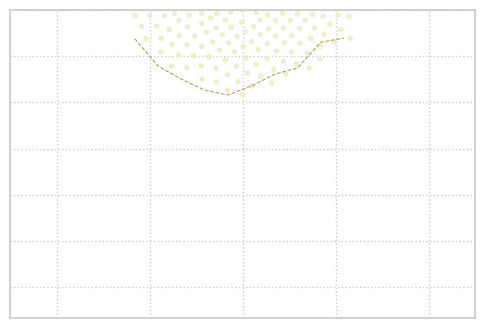

crawl: 0.8, climb 0.6
Curvature: 0.1573


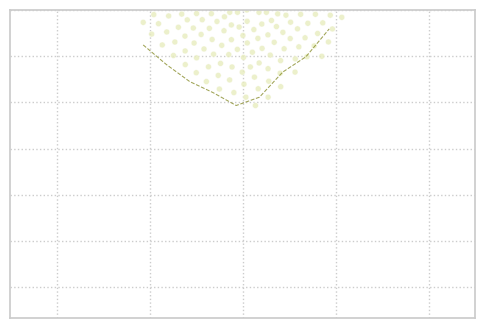

crawl: 0.8, climb 0.8
Curvature: 0.1521


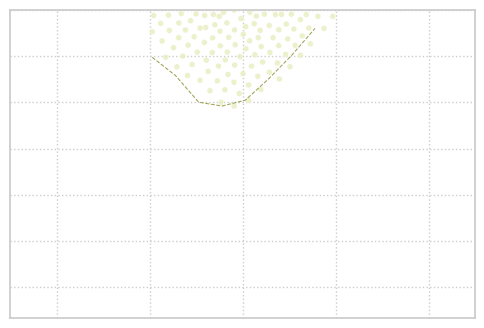

crawl: 0.8, climb 1
Curvature: 0.3155


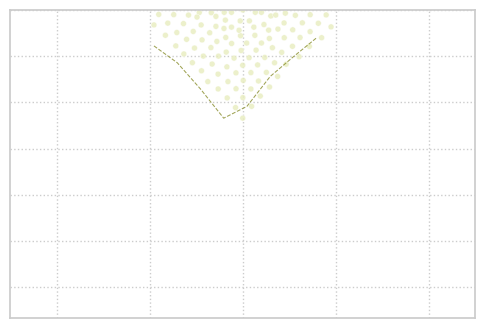

crawl: 1, climb 0
Curvature: 0.1343


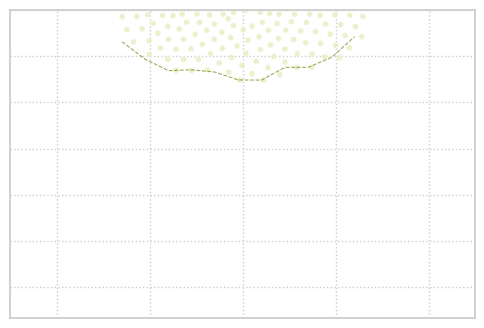

crawl: 1, climb 0.2
Curvature: 0.1049


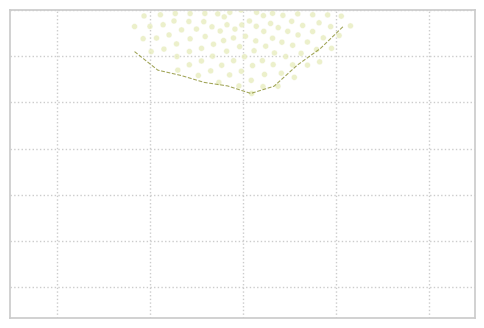

crawl: 1, climb 0.4
Curvature: 0.2278


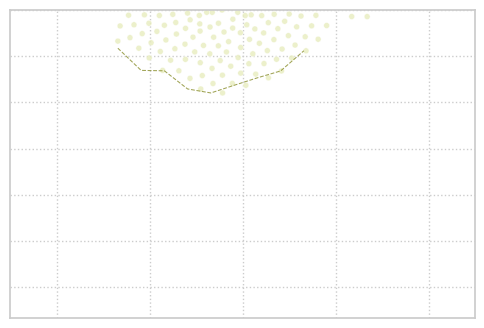

crawl: 1, climb 0.6
Curvature: 0.1366


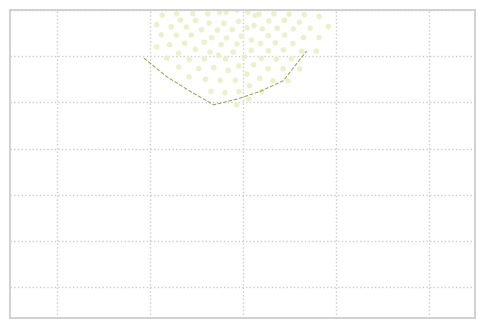

crawl: 1, climb 0.8
Curvature: 0.2735


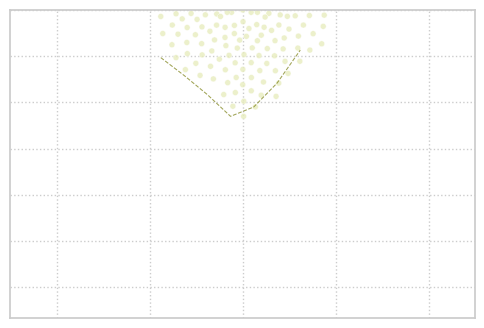

crawl: 1, climb 1
Curvature: 0.3342


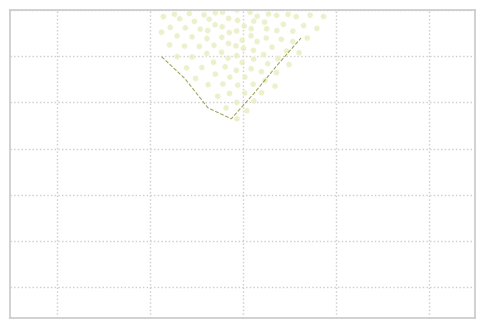

In [95]:
count, size, mass = '100', '0', '0'
crawls = ['0', '0.2', '0.4', '0.6', '0.8', '1']
climbs = ['0', '0.2', '0.4', '0.6', '0.8', '1']
for crawl in crawls:
    for climb in climbs:
        filename = get_filename(crawl, climb, size, mass, count)
        with open(filename, 'r') as file:
            data = json.load(file)
        points = data['points']
        print(f'crawl: {crawl}, climb {climb}')
        display(points)